In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from sklearn import linear_model
from scipy.stats import multivariate_normal

# from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from datetime import datetime, timedelta
from scipy.optimize import minimize


In [2]:
all_data_df = pd.read_csv("owid-covid-data.csv", sep=",")
all_data_df.iso_code.unique()
all_data_df.columns


Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

Добываем из датасета данные по России за интересующий период

In [3]:
ru_data_all = all_data_df[all_data_df.iso_code == "RUS"]
ru_data_all["date_dt"] = pd.to_datetime(ru_data_all["date"])
start = datetime.strptime("2020-03-03", "%Y-%m-%d")
end = start + timedelta(days=50)
ru_data = ru_data_all[((ru_data_all.date_dt >= start) & (ru_data_all.date_dt <= end))]
ru_data["new_cases_no_zero"] = ru_data["new_cases"]
ru_data["new_cases_no_zero"].mask(ru_data["new_cases"] == 0, 1, inplace=True)


C:\Users\BECOMP~1\AppData\Local\Temp/ipykernel_17572/4121357043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ru_data_all['date_dt'] = pd.to_datetime(ru_data_all['date'])
C:\Users\BECOMP~1\AppData\Local\Temp/ipykernel_17572/4121357043.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ru_data['new_cases_no_zero'] = ru_data['new_cases']
D:\Anaconda3\lib\site-packages\pandas\core\generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

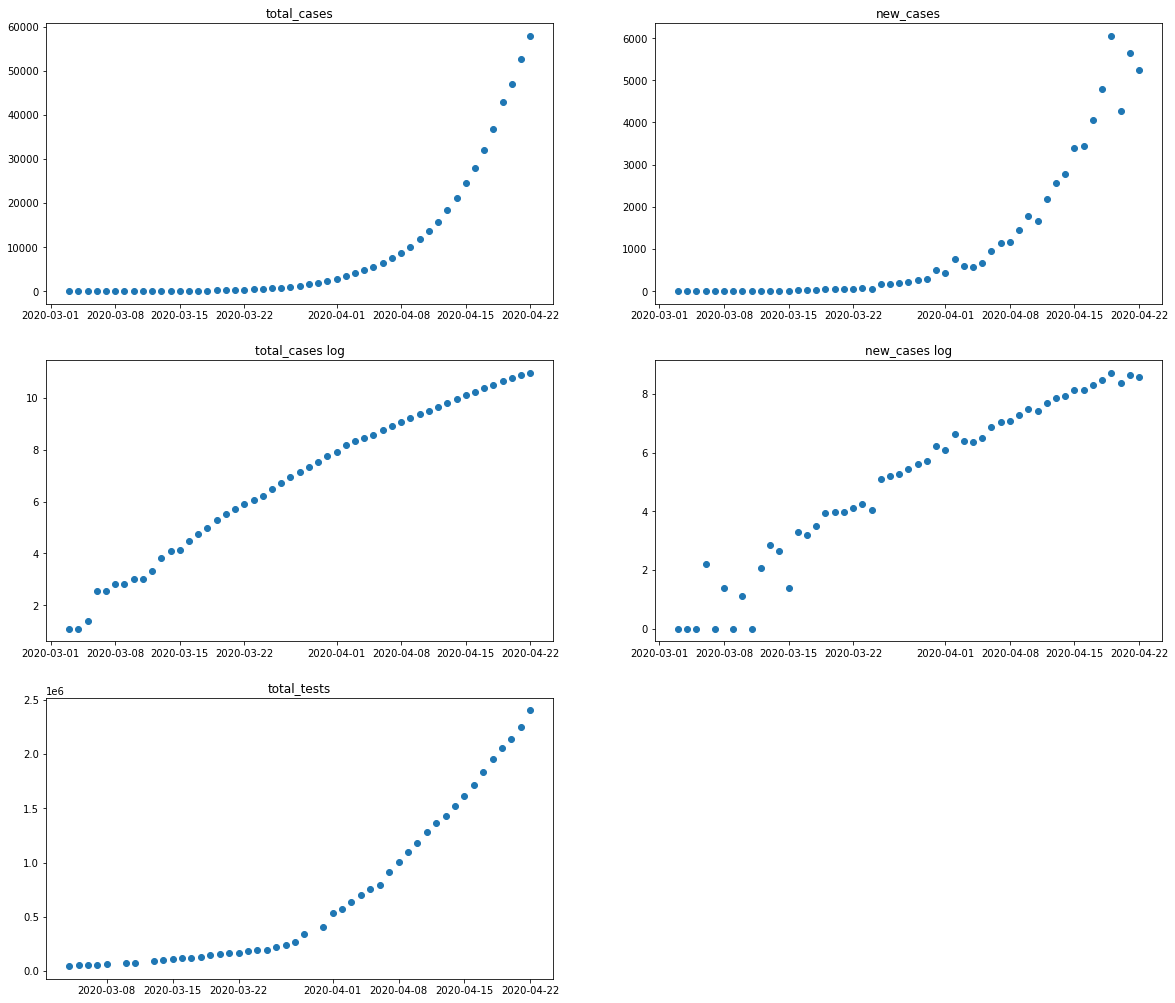

In [4]:
plt.figure(figsize=(20, 30))
plt.subplot(5, 2, 1)
plt.title("total_cases")
plt.scatter(ru_data["date_dt"], ru_data["total_cases"])
plt.subplot(5, 2, 2)
plt.title("new_cases")
plt.scatter(ru_data["date_dt"], ru_data["new_cases_no_zero"])
plt.subplot(5, 2, 3)
plt.title("total_cases log")
plt.scatter(ru_data["date_dt"], np.log(ru_data["total_cases"]))
plt.subplot(5, 2, 4)
plt.title("new_cases log")
plt.scatter(ru_data["date_dt"], np.log(ru_data["new_cases_no_zero"]))
plt.subplot(5, 2, 5)
plt.title("total_tests")
plt.scatter(ru_data["date_dt"], ru_data["total_tests"])
plt.show()


Чтобы получить начальное приближение подбираю "истинные" параметры экспоненты пакетом optimize

Optimization terminated successfully.
         Current function value: 14.650143
         Iterations: 96
         Function evaluations: 182
best parameters [0.1948792  1.98031176]


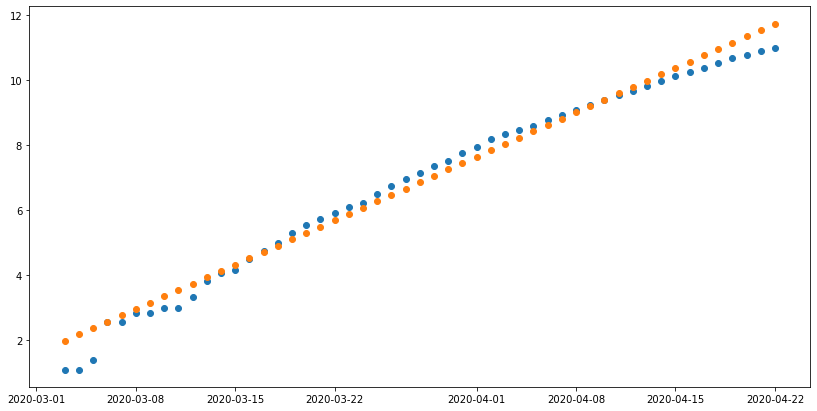

In [24]:
def exp_with_params(param):
    res = 0.0
    for day in np_dataset:
        # print(day)
        res += np.abs(np.log(day[1]) - (param[0] * day[3] + param[1]))
    # print(res)
    return res


np_dataset = ru_data[["date_dt", "total_cases", "new_cases"]].copy()
np_dataset["day_number"] = [(x - start).days for x in (np_dataset["date_dt"])]
np_dataset = np_dataset.to_numpy()

# print(np_dataset)
x0 = np.array([1.0, 1.0])
res = minimize(
    exp_with_params, x0, method="nelder-mead", options={"xatol": 1e-8, "disp": True}
)
print("best parameters", res.x)
plt.figure(figsize=(14, 7))
Y0 = [np.log(x) for x in np_dataset[:, 1]]
plt.scatter(np_dataset[:, 0], Y0)
Y_p = [res.x[0] * x + res.x[1] for x in np_dataset[:, 3]]
plt.scatter(np_dataset[:, 0], Y_p)
plt.show()


Здесь происходит халтура, очень хочется дальше предположить, что ошибка после логорифмирования оказывается распределенной нормально.

Но глядя на QQ-plot и статистики понятно, что это совершенно не так.

Напрашивается два вывода:

    1) экспонента плохая модель
    
    2) предположение про нормальность ошибки лучше бы не делать, но без него дальше очень сложно с правдоподобием



Statistic: 1.385
15.000: 0.539, data does not look normal (reject H0)
10.000: 0.614, data does not look normal (reject H0)
5.000: 0.736, data does not look normal (reject H0)
2.500: 0.859, data does not look normal (reject H0)
1.000: 1.022, data does not look normal (reject H0)
Statistics=7.704, p=0.021
Sample does not look Gaussian (reject H0)
QQ Plot


D:\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


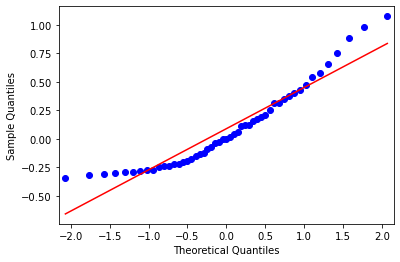

Отклонение логарифма от прямой


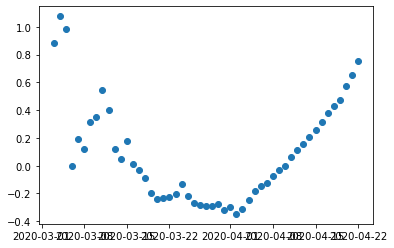

pvariance =  0.13070966991772276


In [25]:

from scipy.stats import normaltest
from scipy.stats import anderson
from statistics import pvariance
from statsmodels.graphics.gofplots import qqplot


data = np.array(Y_p)-np.array(Y0)

# Anderson-Darling Test
result = anderson(data)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))
  
# D'Agostino and Pearson's Test

stat, p = normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')
 

print('QQ Plot')

qqplot(data, line='s')
plt.show()

print('Отклонение логарифма от прямой')
plt.scatter(np_dataset[:,0],  data)
plt.show()

pvar = pvariance(data)
print('pvariance = ', pvar)

Ворую код из лекции, строю широкий гаусс (5 дисперсий ошибки). Центр априорного распределения смещён от реальных значений для честности.

(400, 400)


C:\Users\BECOMP~1\AppData\Local\Temp/ipykernel_17572/2089343799.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet, animated=True)


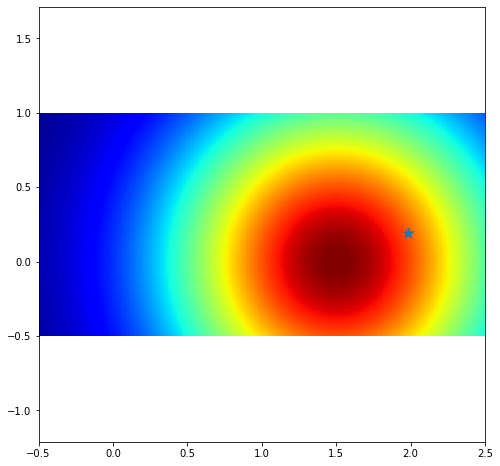

In [26]:
N = 400
true_mu = res.x
xs = np.linspace(-3, 3, N)
X = np.linspace(-1, 2.5, N)
Y = np.linspace(-0.5, 1, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y


def myplot_heatmap(Z):
    # Make the plot
    plt.axis("equal")
    plt.xlim((-0.5, 2.5))
    plt.ylim((-0.5, 1))
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet, animated=True)
    plt.scatter(true_mu[1], true_mu[0], marker="*", s=120)


cur_mu, cur_sigma = np.array([1.5, 0]), 0.65 * np.array([[1, 0], [0, 1]])

Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
print(Z.shape)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
myplot_heatmap(Z)


Запускаю байесовский цикл по точкам, точки перемешал, но, по здравому размышлению, смысла в этом нет. Всё красиво сходится к параметрам, которые нашел optimize.

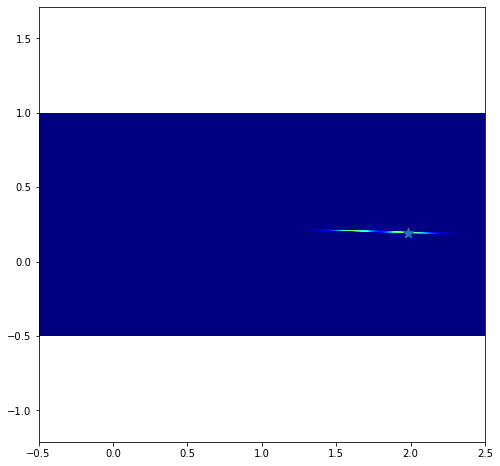

In [27]:
from IPython.display import clear_output
import random


def get_likelihood(px, py, sigma=0.5):
    return lambda x: np.exp(-((x[0] + x[1] * px - py) ** 2)) / (
        2 * sigma * np.sqrt(2.0 * np.pi)
    )


days_list = list(range(50))
random.shuffle(days_list)
for i in days_list:
    plt.pause(0.1)
    px, py = i, Y0[i]
    cur_likelihood = get_likelihood(px, py)
    Z_point = np.array(
        [
            [cur_likelihood(pos[i, j]) for j in range(pos.shape[1])]
            for i in range(pos.shape[0])
        ]
    )
    Z = np.multiply(Z, Z_point).copy()
    print(np.max(Z))
    Z = Z / np.max(Z)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.set_ylim((-2, 2))

    # myplot_heatmap(Z_point)
    myplot_heatmap(Z)
    # myplot_heatmap(Z)
    clear_output(True)


Сэмплирую экспоненты и считаю число заболевших на даты из задания. Получается катастрофически больше.

[(-1.0, -0.4924812030075188), 0.0]


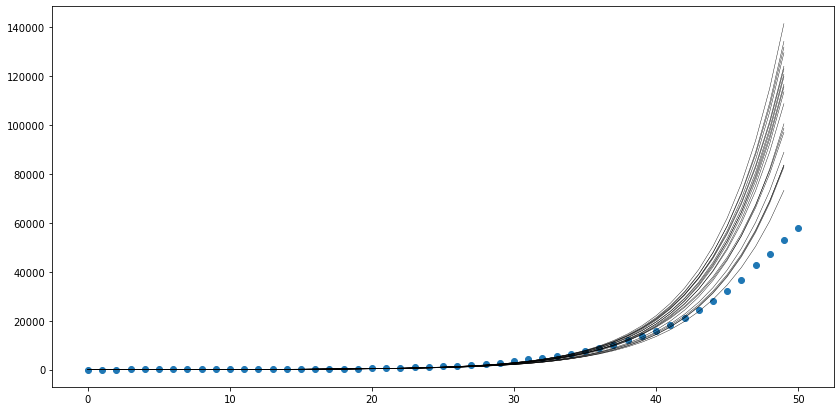

In [9]:
def myplot_sample_lines(mu, sigma, n=20, points=None):
    vals = []
    for j in range(pos.shape[1]):
        for i in range(pos.shape[0]):
            vals.append([(X[i, j], Y[i, j]), Z[i, j]])
    print(vals[2])
    top_nodes = list([x for x in sorted(vals, key=lambda item: item[1], reverse=True)])[
        :200
    ]
    random.shuffle(top_nodes)

    my_w = [x[0] for x in top_nodes[:n]]

    # plt.axis('equal')
    for w in my_w:
        plt.plot(days_e, np.exp(w[0] + w[1] * days_e), "k-", lw=0.4)
    return my_w


plt.figure(figsize=(14, 7))
Y_e = [x for x in np_dataset[:, 1]]
plt.scatter(np_dataset[:, 3], Y_e)
days_e = np.array(list(range(50))).astype("float")
sample_exps = myplot_sample_lines(cur_mu, cur_sigma, 20)


In [10]:
dates = {
    datetime.strptime("2020-05-01", "%Y-%m-%d"): (
        datetime.strptime("2020-05-01", "%Y-%m-%d") - start
    ).days,
    datetime.strptime("2020-06-01", "%Y-%m-%d"): (
        datetime.strptime("2020-06-01", "%Y-%m-%d") - start
    ).days,
    datetime.strptime("2020-09-01", "%Y-%m-%d"): (
        datetime.strptime("2020-09-01", "%Y-%m-%d") - start
    ).days,
}


for d in dates:
    real = ru_data_all[ru_data_all.date_dt == d]["total_cases"].to_numpy()[0]
    predicted = []
    for w in sample_exps:
        predicted.append(np.exp(w[0] + w[1] * dates[d]))
    print(
        f"на {d.date()} реальное число заболевших {int(real)}, экспоненциальная модель предсказывает {int(np.mean(predicted))}"
    )


на 2020-05-01 реальное число заболевших 114431, экспоненциальная модель предсказывает 813167
на 2020-06-01 реальное число заболевших 414328, экспоненциальная модель предсказывает 416280358
на 2020-09-01 реальное число заболевших 997072, экспоненциальная модель предсказывает 52513357833941840


Для того чтобы получить возможность использовать честную линейную регрессию для сигмоиды пришлось прибегнуть к следующим ухищрениям: 

1) Использовать "обратную функцию ошибки"

2) Подобрать нормировочный коэффициент вручную, не смог добиться сходимости если он участвует в байесовском цикле, 

    процесс свалвается в локальные минимумы и уже их не покидает.
    
В остальном аналогично экспоненте

In [11]:
import math


def inv_erf(val):
    def min_opt(x):
        res = np.abs(float(val) - math.erf(x[0]))
        # print(res)
        return res

    x0 = [0.0]
    res = minimize(
        min_opt, x0, method="nelder-mead", options={"xatol": 1e-8, "disp": False}
    )
    # print('best parameters', res.x, val)
    return res.x[0]


best parameters [ 1.00052075e+06  4.12616021e-02 -3.16654613e+00]


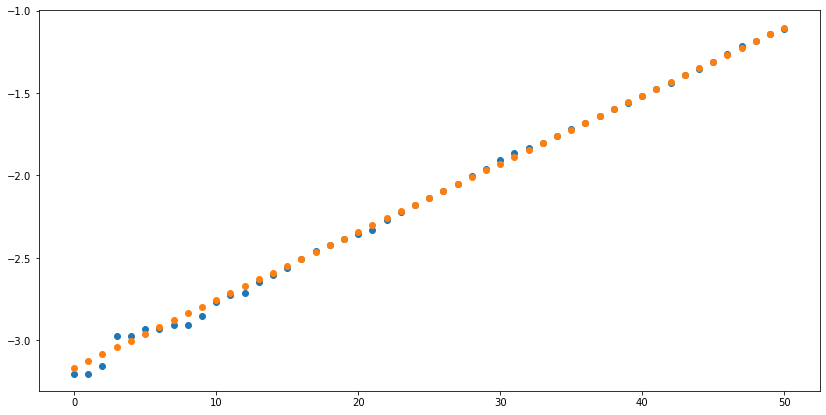

In [12]:
from scipy.optimize import basinhopping


def erf_with_params(param):
    res = 0.0
    for day in np_dataset2:
        # print(day)
        res += np.abs(
            day[1] - param[0] * ((math.erf(param[1] * day[3] + param[2]) + 1) / 2)
        )
    # print(res)
    return res


np_dataset_prepare = ru_data[["date_dt", "total_cases", "new_cases"]].copy()
np_dataset_prepare["day_number"] = [
    (x - start).days for x in (np_dataset_prepare["date_dt"])
]
# np_dataset2['inv_erf'] = [inv_erf(x / np.sqrt(np.pi/2)) for x in (np_dataset2['total_cases'] )]
np_dataset2 = np_dataset_prepare.to_numpy()


# print(np_dataset2)
x0 = np.array([60000, 2, -60])
minimizer_kwargs = {"method": "nelder-mead"}
res = basinhopping(erf_with_params, x0, minimizer_kwargs=minimizer_kwargs)
print("best parameters", res.x)
plt.figure(figsize=(14, 7))
np_dataset_prepare["inv_erf"] = [
    inv_erf((x / res.x[0]) * 2 - 1) for x in (np_dataset_prepare["total_cases"])
]


Y0 = np_dataset_prepare["inv_erf"].to_numpy()
Y0_t = np_dataset_prepare["total_cases"].to_numpy()
plt.scatter(np_dataset2[:, 3], Y0)
Y_p = [
    res.x[0] * ((math.erf(res.x[1] * x + res.x[2]) + 1) / 2) for x in np_dataset2[:, 3]
]
Y_p = [res.x[1] * x + res.x[2] for x in np_dataset2[:, -1]]
plt.scatter(np_dataset2[:, 3], Y_p)
plt.show()


Вообще, здесь ошибка тоже распределена не то что бы нормально, но в целом качество апроксимации заметно лучше.

Statistic: 1.263
15.000: 0.528, data does not look normal (reject H0)
10.000: 0.601, data does not look normal (reject H0)
5.000: 0.721, data does not look normal (reject H0)
2.500: 0.841, data does not look normal (reject H0)
1.000: 1.000, data does not look normal (reject H0)
Statistics=6.091, p=0.048
Sample does not look Gaussian (reject H0)
hist


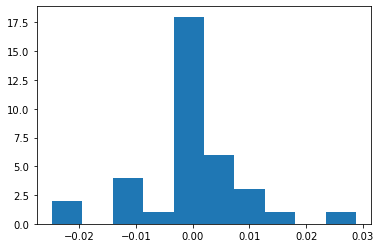

QQ Plot


D:\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


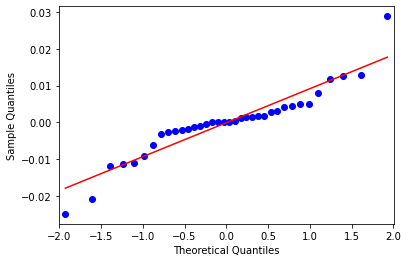

Отклонение значений обратной функции ошибки от прямой


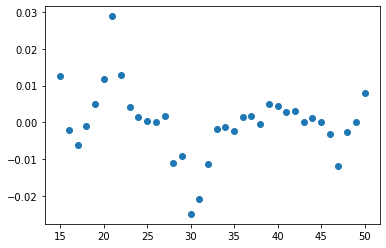

mean = -5.8333333333333414e-05 pvariance =  8.496020833333333e-05


In [13]:
data = np.round(np.array(Y_p[15:]) - np.array(Y0[15:]), 4)

# Anderson-Darling Test
result = anderson(data)
print("Statistic: %.3f" % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print("%.3f: %.3f, data looks normal (fail to reject H0)" % (sl, cv))
    else:
        print("%.3f: %.3f, data does not look normal (reject H0)" % (sl, cv))
# D'Agostino and Pearson's Test

stat, p = normaltest(data)
print("Statistics=%.3f, p=%.3f" % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print("Sample looks Gaussian (fail to reject H0)")
else:
    print("Sample does not look Gaussian (reject H0)")
print("hist")
plt.hist(data)
plt.show()

print("QQ Plot")

qqplot(data, line="s")
plt.show()

print("Отклонение значений обратной функции ошибки от прямой")
plt.scatter(np_dataset[:, 3][15:], data)
plt.show()

pvar = pvariance(data)
print("mean =", np.mean(data), "pvariance = ", pvar)


[ 1.00052075e+06  4.12616021e-02 -3.16654613e+00]
(400, 400)


C:\Users\BECOMP~1\AppData\Local\Temp/ipykernel_17572/2397168815.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet,animated=True)


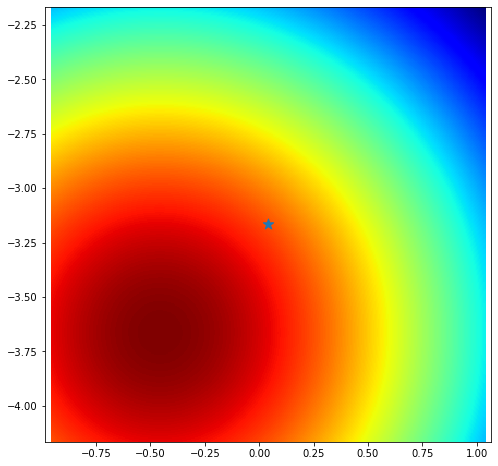

In [14]:
N = 400
true_mu = res.x
print(true_mu)
xs = np.linspace(-3, 3, N)
X = np.linspace(res.x[1] - 1, res.x[1] + 1, N)
Y = np.linspace(res.x[2] - 1, res.x[2] + 1, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y


def myplot_heatmap(Z):
    # Make the plot
    plt.axis("equal")
    plt.xlim((res.x[1] - 1, res.x[1] + 1))
    plt.ylim((res.x[2] - 1, res.x[2] + 1))
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet, animated=True)
    plt.scatter(true_mu[1], true_mu[2], marker="*", s=120)


cur_mu, cur_sigma = np.array([res.x[1] - 0.5, res.x[2] - 0.5]), 2 * np.array(
    [[1, 0], [0, 1]]
)

Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
print(Z.shape)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

myplot_heatmap(Z)


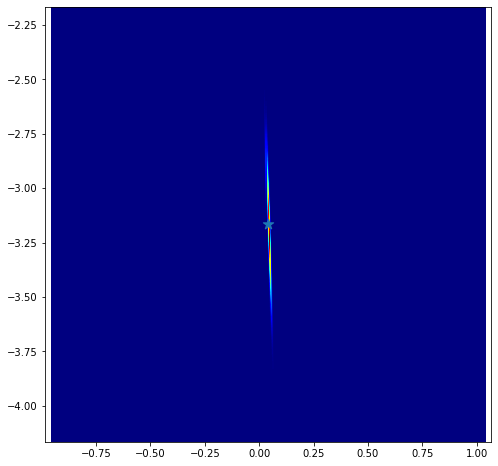

In [15]:
from IPython.display import clear_output
import random


def get_likelihood(px, py, sigma=0.5):
    return lambda x: np.exp(-((x[1] + x[0] * px - py) ** 2)) / (
        2 * sigma * np.sqrt(2.0 * np.pi)
    )


days_list = list(range(50))
random.shuffle(days_list)
for i in days_list:
    plt.pause(0.1)
    px, py = i, Y0[i]
    cur_likelihood = get_likelihood(px, py)
    Z_point = np.array(
        [
            [cur_likelihood(pos[i, j]) for j in range(pos.shape[1])]
            for i in range(pos.shape[0])
        ]
    )
    Z = np.multiply(Z, Z_point).copy()
    print(np.max(Z))
    Z = Z / np.max(Z)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)

    # myplot_heatmap(Z_point)
    myplot_heatmap(Z)
    # myplot_heatmap(Z)
    clear_output(True)


[(-0.9587383978779822, -4.156521069090048), 0.0]


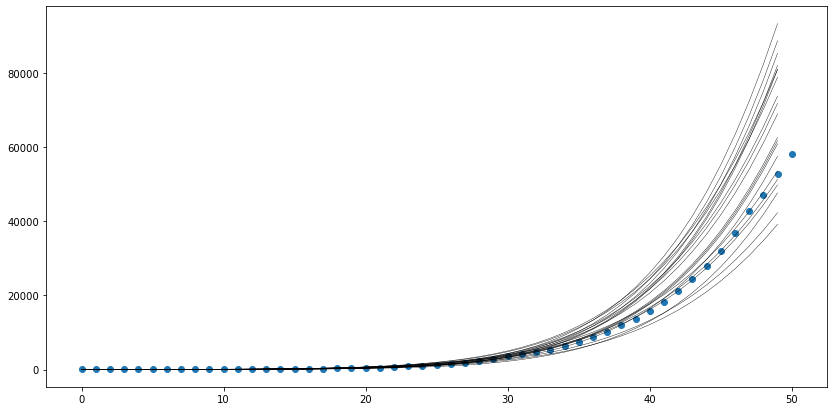

In [16]:
def myplot_sample_lines(mu, sigma, n=20, points=None):
    vals = []
    for j in range(pos.shape[1]):
        for i in range(pos.shape[0]):
            vals.append([(X[i, j], Y[i, j]), Z[i, j]])
    print(vals[2])
    top_nodes = list([x for x in sorted(vals, key=lambda item: item[1], reverse=True)])[
        :100
    ]
    random.shuffle(top_nodes)

    my_w = [x[0] for x in top_nodes[:n]]

    # plt.axis('equal')
    for w in my_w:
        plt.plot(
            days_e,
            [res.x[0] * ((math.erf(w[0] * d + w[1]) + 1) / 2) for d in days_e],
            "k-",
            lw=0.4,
        )
    return my_w


plt.figure(figsize=(14, 7))
Y_e = [x for x in np_dataset[:, 1]]
plt.scatter(np_dataset[:, 3], Y_e)
days_e = np.array(list(range(50))).astype("float")
sample_exps = myplot_sample_lines(cur_mu, cur_sigma, 20)


Предсказания сигмоиды значительно лучше

In [17]:
dates = {
    datetime.strptime("2020-05-01", "%Y-%m-%d"): (
        datetime.strptime("2020-05-01", "%Y-%m-%d") - start
    ).days,
    datetime.strptime("2020-06-01", "%Y-%m-%d"): (
        datetime.strptime("2020-06-01", "%Y-%m-%d") - start
    ).days,
    datetime.strptime("2020-09-01", "%Y-%m-%d"): (
        datetime.strptime("2020-09-01", "%Y-%m-%d") - start
    ).days,
}


for d in dates:
    real = ru_data_all[ru_data_all.date_dt == d]["total_cases"].to_numpy()[0]
    predicted = []
    for w in sample_exps:
        predicted.append(res.x[0] * ((math.erf(w[0] * dates[d] + w[1]) + 1) / 2))
    print(
        f"на {d.date()} реальное число заболевших {int(real)},  модель сигмоидой предсказывает {int(np.mean(predicted))}"
    )


на 2020-05-01 реальное число заболевших 114431,  модель сигмоидой предсказывает 188898
на 2020-06-01 реальное число заболевших 414328,  модель сигмоидой предсказывает 835313
на 2020-09-01 реальное число заболевших 997072,  модель сигмоидой предсказывает 1000520


Основная проблема, которую я так и не победил в процессе - преобразование ошибки при переходе от total_cases к обратным функциям. Честно говоря, осталось ощущение прогала. 